/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 4946 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gaussian_noise (GaussianNo  (None, 7, 7, 512)         0         
 ise)                                                            
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


80/80 [==============================] - ETA: 0s - loss: 0.6064 - accuracy: 0.6940 - precision: 0.7059 - recall: 0.6972 - auc: 0.7614
Epoch 2: val_loss improved from 0.71583 to 0.56229, saving model to mymodel.hdf5
80/80 [==============================] - 24s 306ms/step - loss: 0.6064 - accuracy: 0.6940 - precision: 0.7059 - recall: 0.6972 - auc: 0.7614 - val_loss: 0.5623 - val_accuracy: 0.6833 - val_precision: 0.8140 - val_recall: 0.7609 - val_auc: 0.7166 - lr: 9.0484e-04
Epoch 3/20
80/80 [==============================] - ETA: 0s - loss: 0.5210 - accuracy: 0.7547 - precision: 0.7437 - recall: 0.7556 - auc: 0.8242
Epoch 3: val_loss improved from 0.56229 to 0.55007, saving model to mymodel.hdf5
80/80 [==============================] - 24s 294ms/step - loss: 0.5210 - accuracy: 0.7547 - precision: 0.7437 - recall: 0.7556 - auc: 0.8242 - val_loss: 0.5501 - val_accuracy: 0.7667 - val_precision: 0.8721 - val_recall: 0.8152 - val_auc: 0.7376 - lr: 7.4082e-04
Epoch 4/20
80/80 [===============

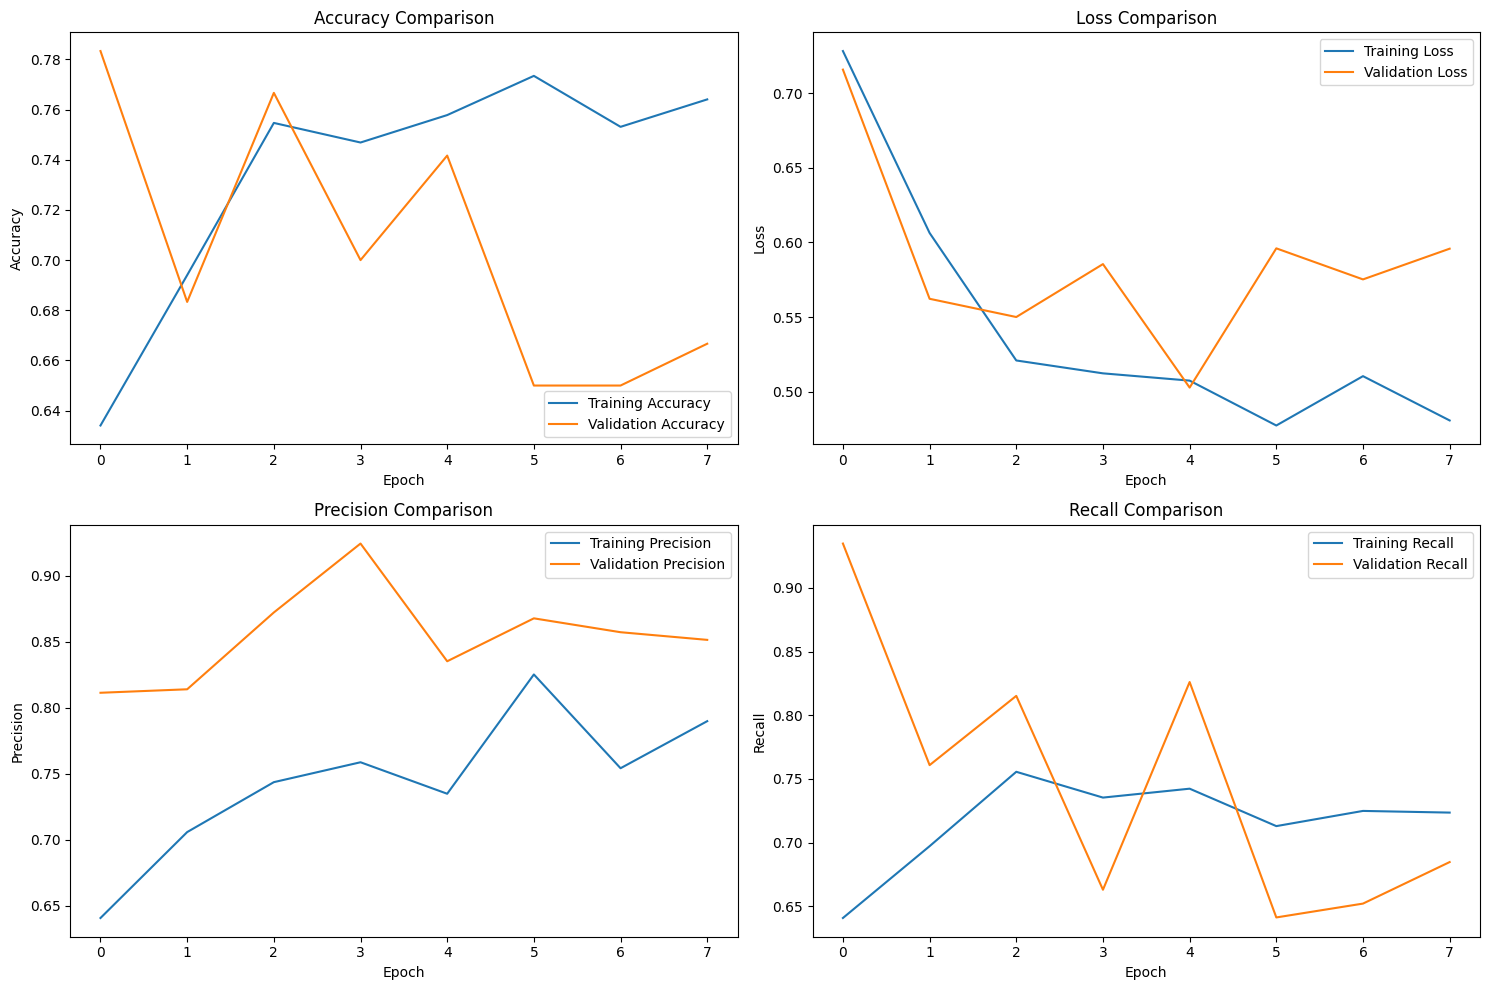

16/16 [==============================] - 7s 441ms/step


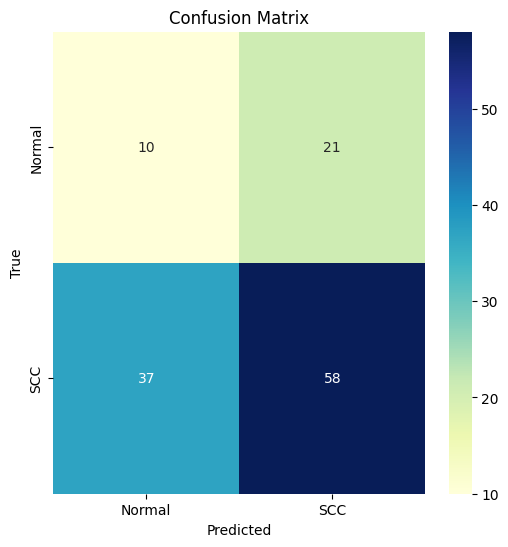

              precision    recall  f1-score   support

           0       0.21      0.32      0.26        31
           1       0.73      0.61      0.67        95

    accuracy                           0.54       126
   macro avg       0.47      0.47      0.46       126
weighted avg       0.61      0.54      0.57       126



In [1]:
# Setup the function libraries
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Define data filepaths
train_set = '../input/dataset/train'
val_set = '../input/dataset/val'
test_set = '../input/dataset/test'

# Data augmentation
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Image addressing
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    val_set,
    target_size=(224, 224),
    batch_size=8,
    shuffle=True,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_set,
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary'
)

# Base model
base_for_model = tf.keras.applications.VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

for layer in base_for_model.layers:
    layer.trainable = False

# Define model settings
model = Sequential()
model.add(base_for_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.summary()

# Compile model
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Callbacks
mp = tf.keras.callbacks.ModelCheckpoint(filepath='mymodel.hdf5', verbose=2, save_best_only=True)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.05, patience=3)
lr_schedule = LearningRateScheduler(lambda epoch, lr: lr * tf.math.exp(-0.1 * epoch))
tensorboard_callback = TensorBoard(log_dir="./logs")
callback = [es, mp, lr_schedule, tensorboard_callback]

# Training
history = model.fit(
    train_generator,
    steps_per_epoch=80,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callback
)

# Visualization
plt.figure(figsize=(15, 10))

# Plot accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot precision
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision Comparison')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall Comparison')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

# Model evaluation
model.evaluate(train_generator)
model.evaluate(validation_generator)
model.evaluate(test_generator)

# Confusion matrix
predictions = model.predict(test_generator)
cm = confusion_matrix(test_generator.classes, predictions.round())

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=['Normal', 'SCC'], yticklabels=['Normal', 'SCC'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(test_generator.classes, predictions.round()))